### 02 Model Training and Evaluation

This notebook performs supervised learning using:
- MLP (Neural Network) (RELU,tanh)
- Random Forest
- XGBoost
- Stacking Ensemble (RF + XGB → Logistic Regression)

Evaluation strategy:
- 5-fold cross-validation on training data (80%)
- Final evaluation on held-out test data (20%)

Visualisations (Test set):
- ROC curve
- Precision–Recall curve
- Confusion matrix
- Calibration curve

Import Library

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import joblib

Random Seed

In [3]:
SEED = 42
np.random.seed(SEED)

Load preprocessed data from 01_preprocessing

In [4]:
X_train = joblib.load("X_train_trans.joblib")
X_test  = joblib.load("X_test_trans.joblib")
y_train = joblib.load("y_train.joblib")
y_test  = joblib.load("y_test.joblib")

feature_names = joblib.load("feature_names.joblib")

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nTrain label distribution:\n", y_train.value_counts(normalize=True))

Train shape: (17386, 87)
Test shape: (4347, 87)

Train label distribution:
 Depression
1    0.551363
0    0.448637
Name: proportion, dtype: float64


Cross-validation setup & evaluation metrics

In [5]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=SEED
)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "auc": "roc_auc"
}

Evaluation Functions (Cross-Validation Summary and Test Metrics)

In [ ]:
def summarize_cv(name, cv_results):
    print(f"\n=== {name} | 5-Fold CV (Train 80%) ===")
    for k, v in cv_results.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            print(f"{metric}: {np.mean(v):.4f} ± {np.std(v):.4f}")


def evaluate_on_test(name, model, X_test, y_test, threshold=0.5):
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(int)

    print(f"\n=== {name} | Test Set (20%) ===")
    print("AUC:", roc_auc_score(y_test, proba))
    print(classification_report(y_test, pred, digits=4))

    return {
        "Model": name,
        "AUC": roc_auc_score(y_test, proba),
        "F1": f1_score(y_test, pred),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred)
    }


### Multilayer Perceptron (MLP)


1. ReLU Activation

In [17]:
mlp_relu = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=SEED
)

mlp_relu_cv = cross_validate(mlp_relu, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("MLP (ReLU)", mlp_relu_cv)

mlp_relu.fit(X_train, y_train)

# store proba & pred for plots
mlp_relu_proba = mlp_relu.predict_proba(X_test)[:, 1]
mlp_relu_pred = (mlp_relu_proba >= 0.5).astype(int)

# metrics table output
mlp_relu_metrics = evaluate_on_test("MLP (ReLU)", mlp_relu, X_test, y_test)


=== MLP (ReLU) | 5-Fold CV (Train 80%) ===
accuracy: 0.8414 ± 0.0055
precision: 0.8488 ± 0.0084
recall: 0.8670 ± 0.0060
f1: 0.8577 ± 0.0045
auc: 0.9183 ± 0.0045

=== MLP (ReLU) | Test Set (20%) ===
AUC: 0.9184923462019832
              precision    recall  f1-score   support

           0     0.8270    0.8210    0.8240      1950
           1     0.8552    0.8602    0.8577      2397

    accuracy                         0.8427      4347
   macro avg     0.8411    0.8406    0.8409      4347
weighted avg     0.8426    0.8427    0.8426      4347



2. tanh Activation

In [ ]:
mlp_tanh = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="tanh",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=SEED
)

mlp_tanh_cv = cross_validate(mlp_tanh, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("MLP (tanh)", mlp_tanh_cv)

mlp_tanh.fit(X_train, y_train)

# store proba & pred for plots
mlp_tanh_proba = mlp_tanh.predict_proba(X_test)[:, 1]
mlp_tanh_pred = (mlp_tanh_proba >= 0.5).astype(int)

# metrics table output
mlp_tanh_metrics = evaluate_on_test("MLP (tanh)", mlp_tanh, X_test, y_test)


=== MLP (tanh) | 5-Fold CV (Train 80%) ===
accuracy: 0.8415 ± 0.0047
precision: 0.8522 ± 0.0101
recall: 0.8623 ± 0.0094
f1: 0.8571 ± 0.0037
auc: 0.9188 ± 0.0048

=== MLP (tanh) | Test Set (20%) ===
AUC: 0.9197642352085407
              precision    recall  f1-score   support

           0     0.8392    0.8133    0.8260      1950
           1     0.8519    0.8732    0.8624      2397

    accuracy                         0.8463      4347
   macro avg     0.8455    0.8433    0.8442      4347
weighted avg     0.8462    0.8463    0.8461      4347



3. sigmoid/logistic Activation

In [ ]:
mlp_sigmoid = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="logistic",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=SEED
)

mlp_sigmoid_cv = cross_validate(mlp_sigmoid, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("MLP (sigmoid)", mlp_sigmoid_cv)

mlp_sigmoid.fit(X_train, y_train)

# store proba & pred for plots
mlp_sigmoid_proba = mlp_sigmoid.predict_proba(X_test)[:, 1]
mlp_sigmoid_pred = (mlp_sigmoid_proba >= 0.5).astype(int)

# metrics table output
mlp_sigmoid_metrics = evaluate_on_test("MLP (sigmoid)", mlp_sigmoid, X_test, y_test)


=== MLP (sigmoid) | 5-Fold CV (Train 80%) ===
accuracy: 0.8425 ± 0.0041
precision: 0.8468 ± 0.0044
recall: 0.8722 ± 0.0121
f1: 0.8593 ± 0.0047
auc: 0.9200 ± 0.0043

=== MLP (sigmoid) | Test Set (20%) ===
AUC: 0.9199546441599007
              precision    recall  f1-score   support

           0     0.8336    0.8221    0.8278      1950
           1     0.8568    0.8665    0.8616      2397

    accuracy                         0.8466      4347
   macro avg     0.8452    0.8443    0.8447      4347
weighted avg     0.8464    0.8466    0.8465      4347



### Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=SEED,
    n_jobs=-1
)

rf_cv = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("Random Forest", rf_cv)

rf.fit(X_train, y_train)

# store proba & pred for plots
rf_proba = rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_proba >= 0.5).astype(int)

# metrics table output
rf_metrics = evaluate_on_test("Random Forest", rf, X_test, y_test)


=== Random Forest | 5-Fold CV (Train 80%) ===
accuracy: 0.8396 ± 0.0074
precision: 0.8445 ± 0.0072
recall: 0.8692 ± 0.0075
f1: 0.8567 ± 0.0066
auc: 0.9159 ± 0.0041

=== Random Forest | Test Set (20%) ===
AUC: 0.9158885572777938
              precision    recall  f1-score   support

           0     0.8368    0.8046    0.8204      1950
           1     0.8459    0.8723    0.8589      2397

    accuracy                         0.8420      4347
   macro avg     0.8413    0.8385    0.8396      4347
weighted avg     0.8418    0.8420    0.8416      4347



### XGBoost

In [ ]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=SEED,
    n_jobs=-1
)

xgb_cv = cross_validate(xgb, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("XGBoost", xgb_cv)

xgb.fit(X_train, y_train)

# store proba & pred for plots
xgb_proba = xgb.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

# metrics table output
xgb_metrics = evaluate_on_test("XGBoost", xgb, X_test, y_test)


=== XGBoost | 5-Fold CV (Train 80%) ===
accuracy: 0.8427 ± 0.0059
precision: 0.8479 ± 0.0054
recall: 0.8710 ± 0.0080
f1: 0.8593 ± 0.0055
auc: 0.9191 ± 0.0053

=== XGBoost | Test Set (20%) ===
AUC: 0.9187557095942576
              precision    recall  f1-score   support

           0     0.8403    0.8123    0.8261      1950
           1     0.8513    0.8744    0.8627      2397

    accuracy                         0.8466      4347
   macro avg     0.8458    0.8434    0.8444      4347
weighted avg     0.8464    0.8466    0.8463      4347



### Stacking Ensemble (RF + XGB → Logistic Regression)

In [ ]:
stack = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    final_estimator=LogisticRegression(max_iter=2000),
    stack_method="predict_proba",
    passthrough=False,
    n_jobs=-1
)

stack_cv = cross_validate(stack, X_train, y_train, cv=cv, scoring=scoring)
summarize_cv("Stacking (RF+XGB→LR)", stack_cv)

stack.fit(X_train, y_train)

# store proba & pred for plots
stack_proba = stack.predict_proba(X_test)[:, 1]
stack_pred = (stack_proba >= 0.5).astype(int)

# metrics table output
stack_metrics = evaluate_on_test("Stacking Ensemble", stack, X_test, y_test)


=== Stacking (RF+XGB→LR) | 5-Fold CV (Train 80%) ===
accuracy: 0.8425 ± 0.0053
precision: 0.8484 ± 0.0053
recall: 0.8698 ± 0.0071
f1: 0.8590 ± 0.0049
auc: 0.9190 ± 0.0043

=== Stacking Ensemble | Test Set (20%) ===
AUC: 0.9189476161441118
              precision    recall  f1-score   support

           0     0.8392    0.8164    0.8277      1950
           1     0.8539    0.8728    0.8632      2397

    accuracy                         0.8475      4347
   macro avg     0.8465    0.8446    0.8454      4347
weighted avg     0.8473    0.8475    0.8473      4347



### Model Comparison Table

In [30]:
results_df = pd.DataFrame([
    mlp_relu_metrics,
    mlp_tanh_metrics,
    mlp_sigmoid_metrics,
    rf_metrics,
    xgb_metrics,
    stack_metrics
])

results_df


,Model,AUC,F1,Accuracy,Precision,Recall
0,MLP (ReLU),0.918492,0.857737,0.842650,0.855247,0.860242
1,MLP (tanh),0.919764,0.862382,0.846331,0.851852,0.873175
2,MLP (sigmoid),0.919955,0.861647,0.846561,0.856848,0.866500
3,Random Forest,0.915889,0.858903,0.841960,0.845874,0.872340
4,XGBoost,0.918756,0.862729,0.846561,0.851340,0.874426
5,Stacking Ensemble,0.918948,0.863214,0.847481,0.853878,0.872758


Store probas/preds for plotting

In [25]:
probas = {
    "MLP (ReLU)": mlp_relu_proba,
    "MLP (tanh)": mlp_tanh_proba,
    "MLP (sigmoid)": mlp_sigmoid_proba,
    "Random Forest": rf_proba,
    "XGBoost": xgb_proba,
    "Stacking": stack_proba
}

preds = {
    "MLP (ReLU)": mlp_relu_pred,
    "MLP (tanh)": mlp_tanh_pred,
    "MLP (sigmoid)": mlp_sigmoid_pred,
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "Stacking": stack_pred
}

### Performance Visualisation (Test Set)

1. ROC Curve

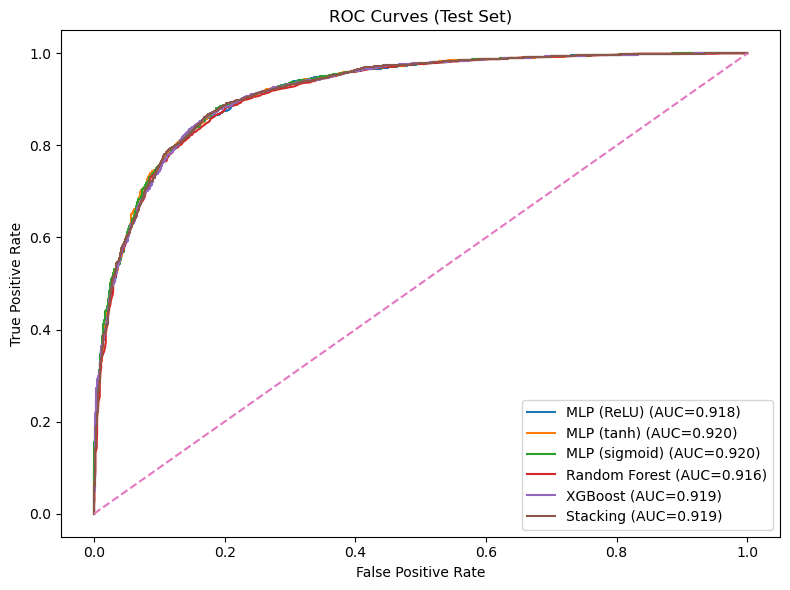

In [26]:
plt.figure(figsize=(8, 6))

for name, proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

2. Precision–Recall Curves

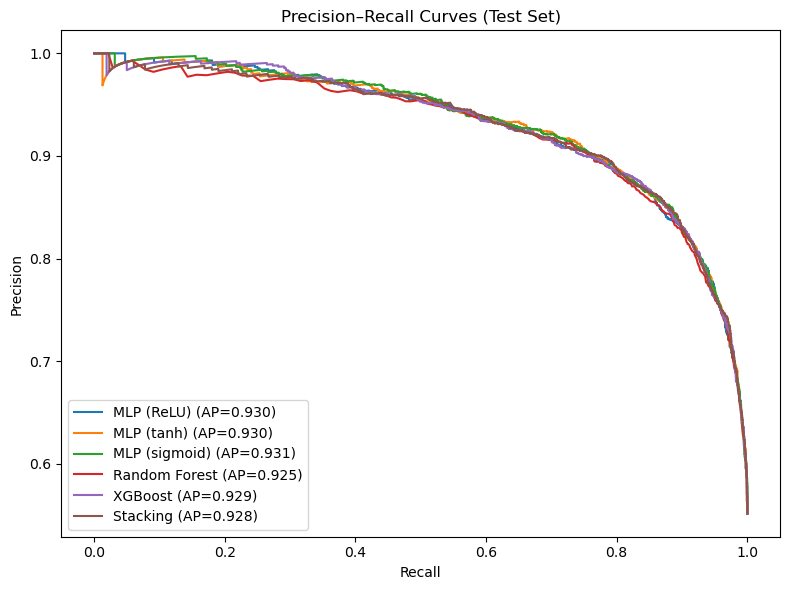

In [27]:
plt.figure(figsize=(8, 6))

for name, proba in probas.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


3. Confusion Matrices 

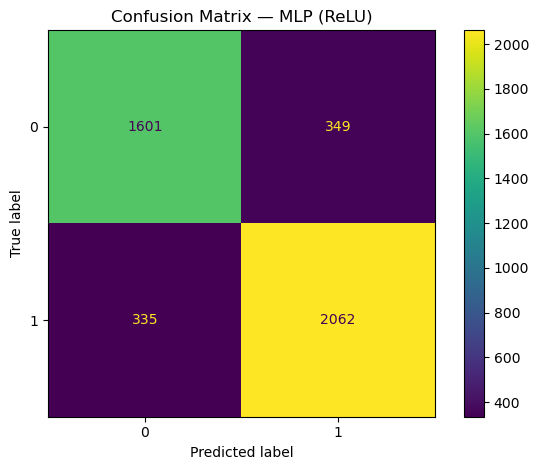

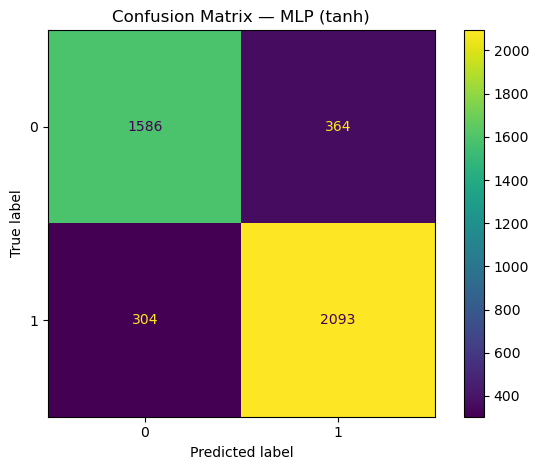

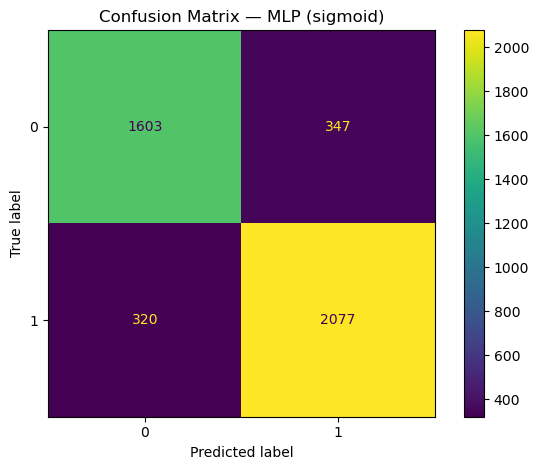

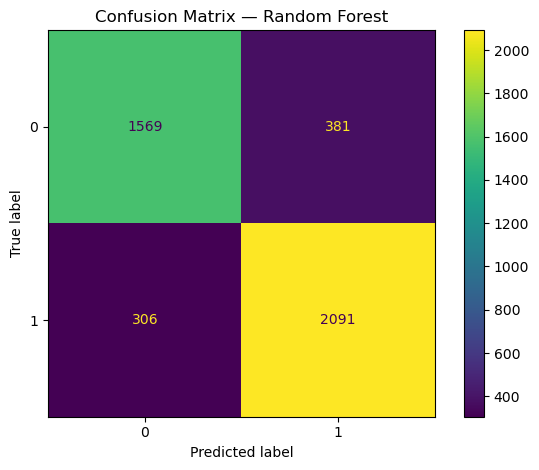

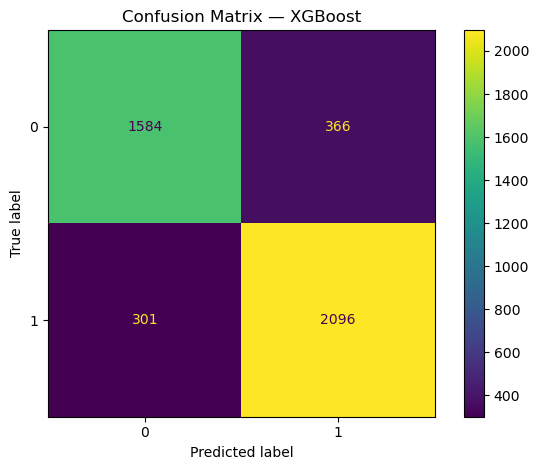

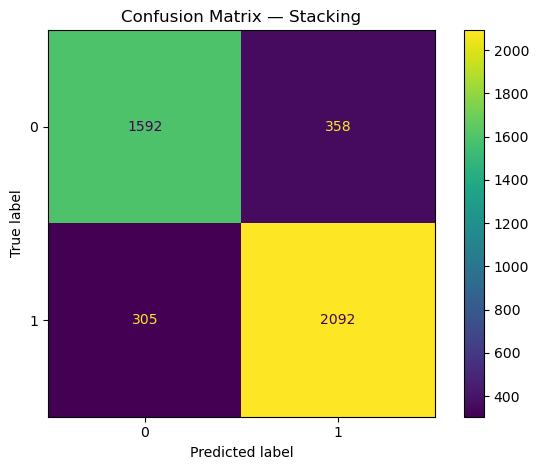

In [28]:
for name, pred in preds.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()


4. Calibration Curves

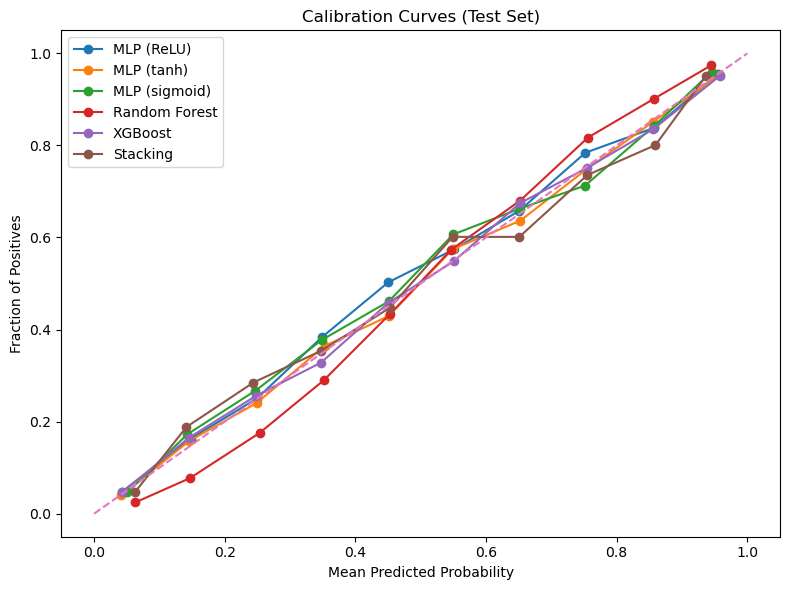

In [29]:
plt.figure(figsize=(8, 6))

for name, proba in probas.items():
    frac_pos, mean_pred = calibration_curve(
        y_test, proba, n_bins=10, strategy="uniform"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


Saving Trained Models for Explainability

In [32]:
joblib.dump(mlp_relu, "mlp_relu_model.joblib")
joblib.dump(mlp_tanh, "mlp_tanh_model.joblib")
joblib.dump(mlp_sigmoid, "mlp_sigmoid_model.joblib")

joblib.dump(rf, "rf_model.joblib")
joblib.dump(xgb, "xgb_model.joblib")
joblib.dump(stack, "stacking_model.joblib")

print("Saved trained models:")
print("- mlp_relu_model.joblib")
print("- mlp_tanh_model.joblib")
print("- mlp_sigmoid_model.joblib")
print("- rf_model.joblib")
print("- xgb_model.joblib")
print("- stacking_model.joblib")


Saved trained models:
- mlp_relu_model.joblib
- mlp_tanh_model.joblib
- mlp_sigmoid_model.joblib
- rf_model.joblib
- xgb_model.joblib
- stacking_model.joblib
